In [1]:
# Basic set of Python Data Analysis
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.width',180)
pd.set_option('display.max_colwidth', 20)

## for plot by matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
from cycler import cycler
import seaborn as sns

# for plot by matplotlib
sns.set(font="DejaVu Sans", font_scale=1.8,
        rc={'figure.figsize': (10, 10),
            'lines.markersize': 15,
            "animation.embed_limit": 100})
sns.mpl.rc("axes", prop_cycle
           =cycler('color', ['#E24A33', '#348ABD', '#988ED5',
                             '#777777', '#FBC15E', '#8EBA42',
                             '#FFB5B8']))
sns.set_style('darkgrid', {'axes.facecolor': "0.8"})

# for markers
marker = itertools.cycle(('o', 'v', '^', 'D', '+', 'X', '<', '>'))
colors = itertools.cycle(('#E24A33', '#348ABD', '#988ED5', '#777777',
                          '#FBC15E', '#8EBA42', '#FFB5B8'))


## for machine learning with scikit learn
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture

## PCCA+ from pyemma
from pyemma.msm import PCCA

## don't show warning
import warnings
warnings.filterwarnings('ignore')

# import the Escal Tools
import os, sys
sys.path.append(os.path.expanduser("../../toolkits"))
import basicTools as bt
import Etranform as et
from mapTools import linear as mt
from importlib import reload

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Parameters

In [2]:
## the data directory
datadir = os.path.realpath("../../data")
fname = "350"
filePref = f"{datadir}/{fname}"
print("The analysis will do for: \n", filePref)

## The data per frames
skip = 1

### smooth
step    = 100
width   = 200
seg2vec = bt.segment.medoid

### similar metrix
similar = bt.dist.cosin

### evalute method
evalute = bt.evalute.cluster

The analysis will do for: 
 /home/ghzuo/data/gromacs/data.Chignolin/5awl/unfolding/350


# The Input Data

## Structure of Trajectory

In [3]:
## read data from file
dih = pd.DataFrame(np.loadtxt(f"{filePref}-rama.xvg", comments=["@","#"],
                             dtype = {'names': ('Phi', 'Psi', 'Residue'),
                                     'formats': ('f', 'f', 'S7')}))
print("The shape of input file is: ", dih.shape)
X0 = bt.feature.dih2X(dih)
X0 = X0.loc[1::skip,:].reset_index(drop=True)
X0 = np.array(X0)
print("The shape of X0 is: ", X0.shape)
Xx = (X0 - np.mean(X0, axis=0))/np.std(X0,axis=0)
print("The shape of Xx is: ", Xx.shape)

The shape of input file is:  (800008, 3)
The shape of X0 is:  (100000, 32)
The shape of Xx is:  (100000, 32)


## Energy of Trajectory

In [4]:
## read the energy data
eng = pd.DataFrame(np.loadtxt(f"{filePref}-potential.xvg", comments=["@","#"],
                             dtype = {'names': ('time', 'energy'), 
                                     'formats': ('f', 'f')}))

### base frequence in MHz
## 1000,000 for M and P, and 2 for even extension
ufreq = 500000/eng.loc[len(eng)-1, "time"]
print("The base frequence is {:.4f} MHz".format(ufreq))

E0 = np.array(eng.loc[1::skip, 'energy'])
print("The shape of Energy is: ", E0.shape)

The base frequence is 0.5000 MHz
The shape of Energy is:  (100000,)


## RMSD from Native Structure

In [5]:
rms = np.loadtxt(f"{filePref}-CaRMS.xvg", comments=["@","#"],
                 dtype = {'names': ('time', 'rms'), 
                          'formats': ('f', 'f')})
rms = rms[1::skip]
print("The shape of RMS is: ", rms.shape)

The shape of RMS is:  (100000,)


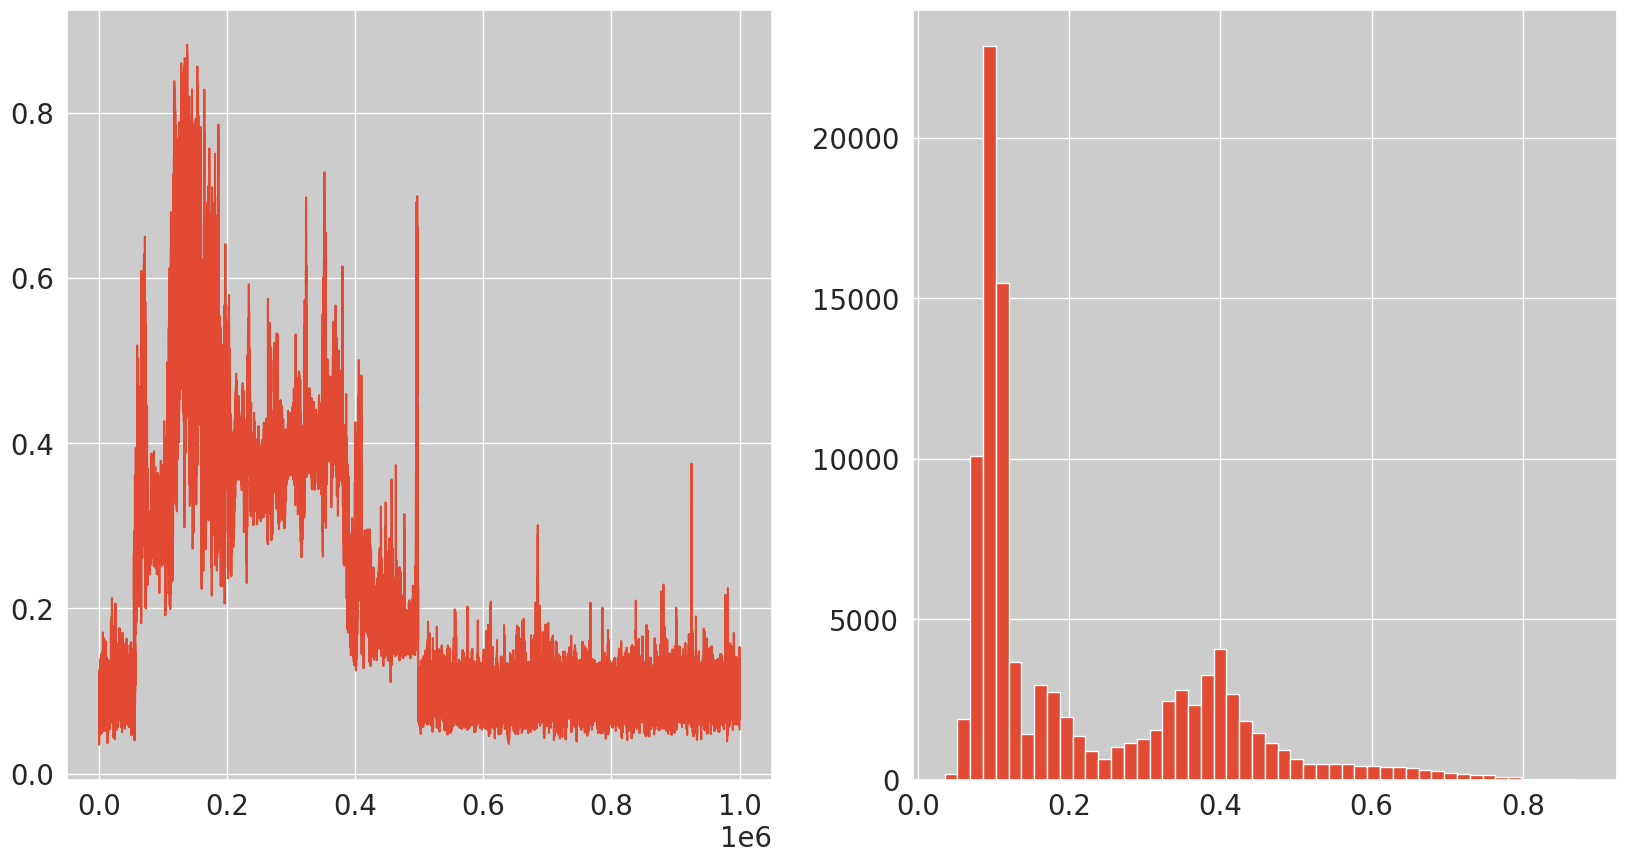

In [6]:
plt.figure(12,figsize=(20,10))
ax = plt.subplot(121)
ax.plot(rms['time'], rms['rms'])
ax = plt.subplot(122)
hist = ax.hist(rms["rms"], bins=50, )

# Multiple Correlation Coefficient

In [7]:
## do FFT rescaling
efft = et.Efft(Xx, E0)

## set the mapping tool
xmap = mt.LinearRegress(efft)

## get the score
qmc = xmap.score()

Text(19.7, 0.9149188439060902, '#15 (7.0 MHz)\nQMC = 0.93')

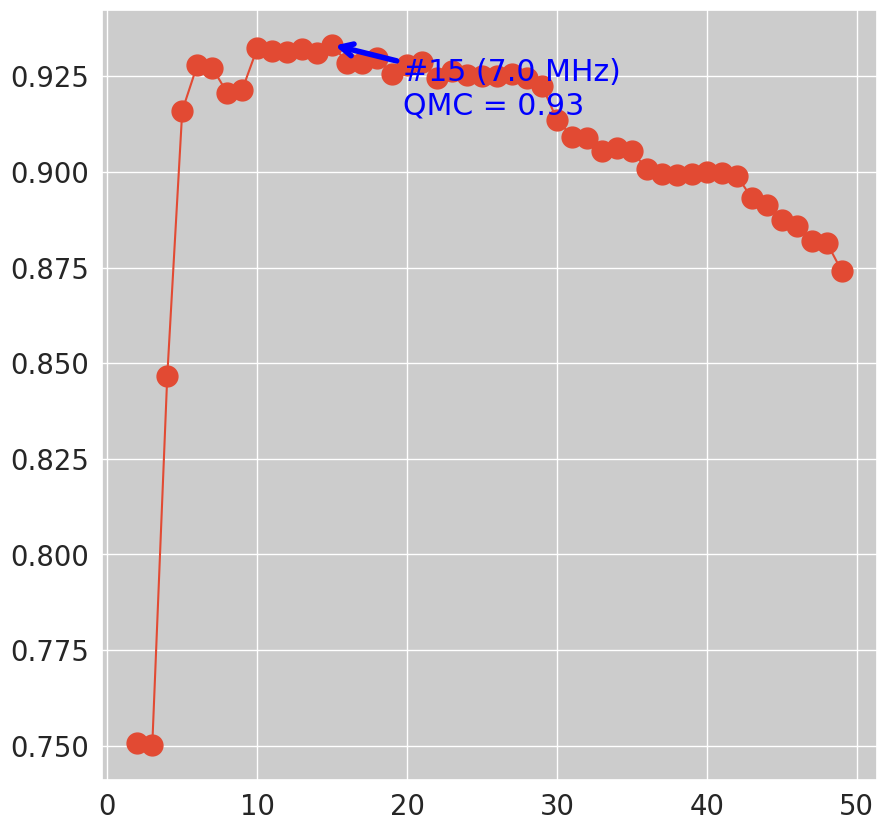

In [8]:
## plot the multiple correlation coefficient
plt.plot(qmc['list'][:,0],qmc['list'][:,1], marker="o")

## annotate the peak value
xy    = (qmc['KappaMax'], qmc['qmcMax'])
offset = 0.1 * (np.max(qmc['list'], axis=0)-np.min(qmc['list'],axis=0))
xytxt  = [xy[0] + offset[0], xy[1] - offset[1]]
plt.annotate("#{:d} ({:.1f} MHz)\nQMC = {:.2f}"
            .format(int(xy[0]), (xy[0]-1)*ufreq, xy[1]), 
            xy=xy, xytext=xytxt, color='blue', 
            arrowprops=dict(arrowstyle="->", color='blue', lw=4))

# Scaling for Selected Kappa

In [9]:
kappa = qmc['KappaMax']
rescl = xmap.scale(kappa)

## Weight of Features

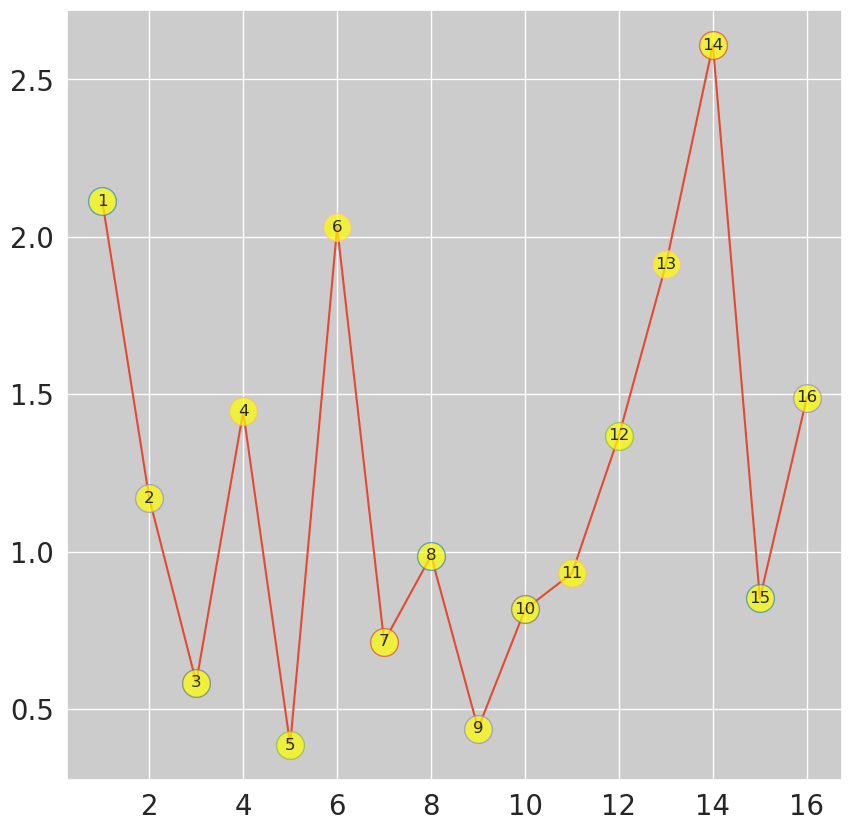

In [10]:
bt.plot.coefplot(bt.feature.dihCombind(rescl['A']))

## Effective Energy

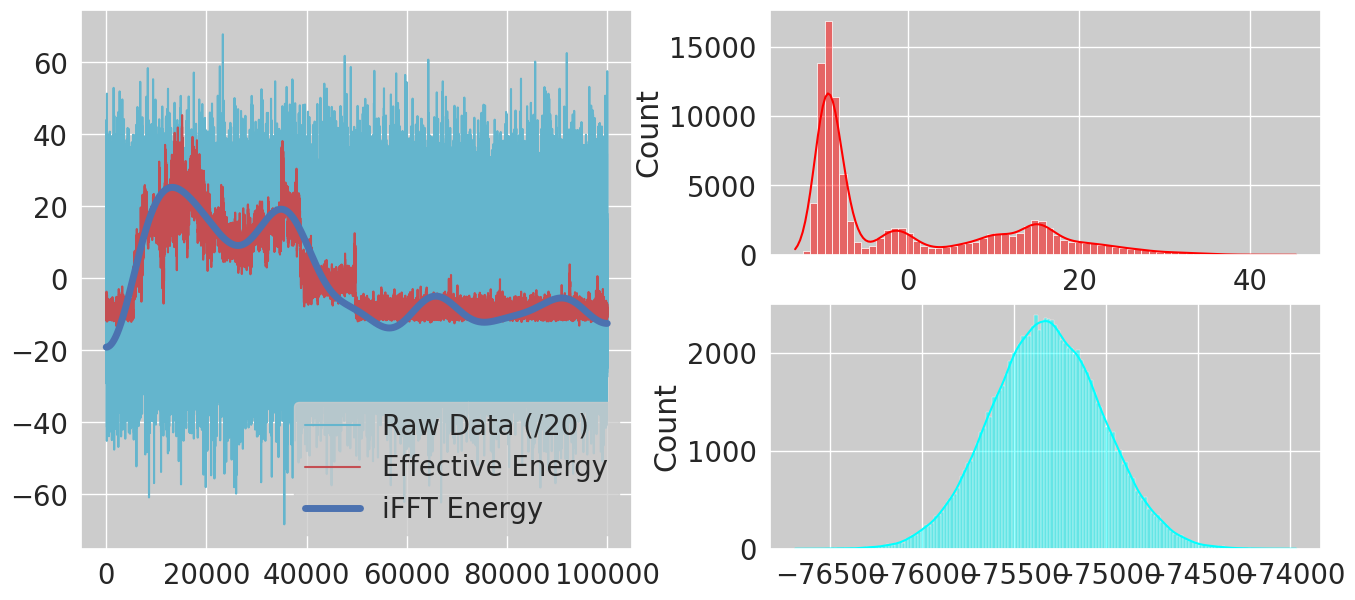

In [11]:
## plot the effective energy
bt.plot.efplot(E0, efft.Ef(kappa), rescl['Ee'])

# Matrix Analysis

## Sample Data

In [12]:
## get the samples
X0s = seg2vec(Xx, step, width)
Xys = seg2vec(rescl['X'], step, width)

## Testing Similarity Matrix

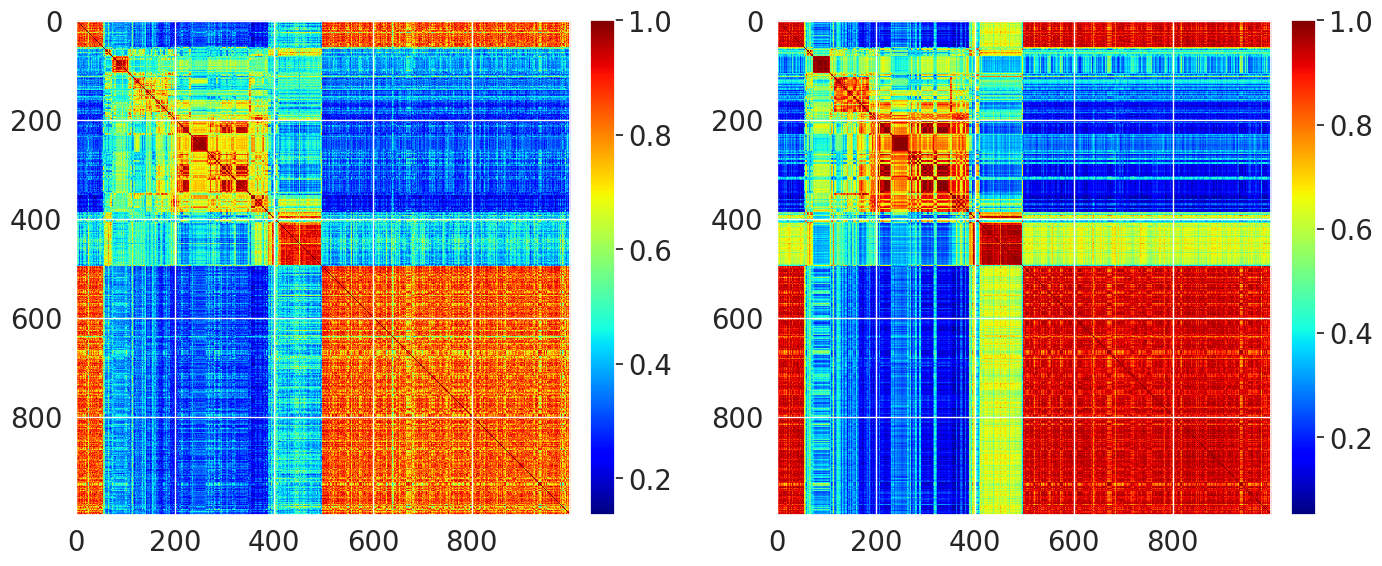

In [13]:
## set distance function and get distance
Smat0  = similar(X0s)
Smaty  = similar(Xys)
    
### plot
fig, axs = plt.subplots(1,2, figsize=(16,32))
fig.subplots_adjust(wspace=0.3)
bt.plot.implot(Smat0, axs[0])
bt.plot.implot(Smaty, axs[1])

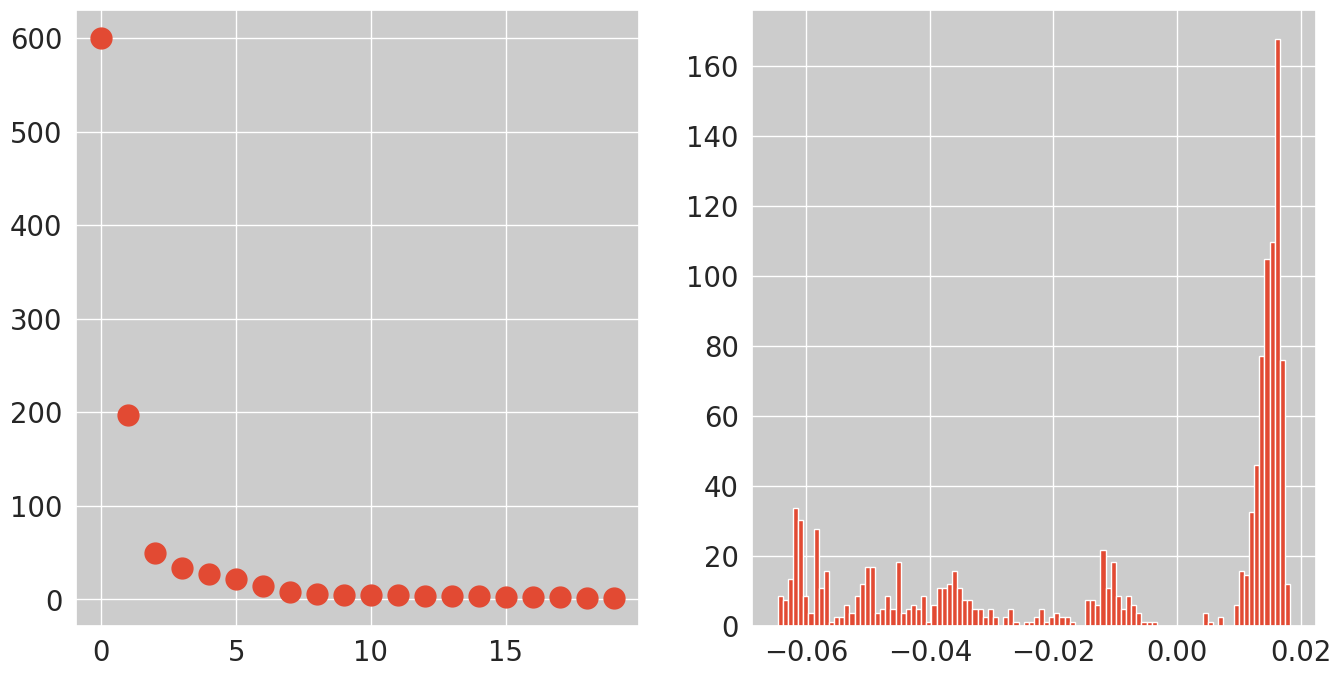

In [14]:
w,v = np.linalg.eig(Smaty)

fig, axs = plt.subplots(1,2, figsize=(16,8)) 
axs[0].plot(w[0:20], "o")
hist = axs[1].hist(v[:,1], bins=100, density=True)

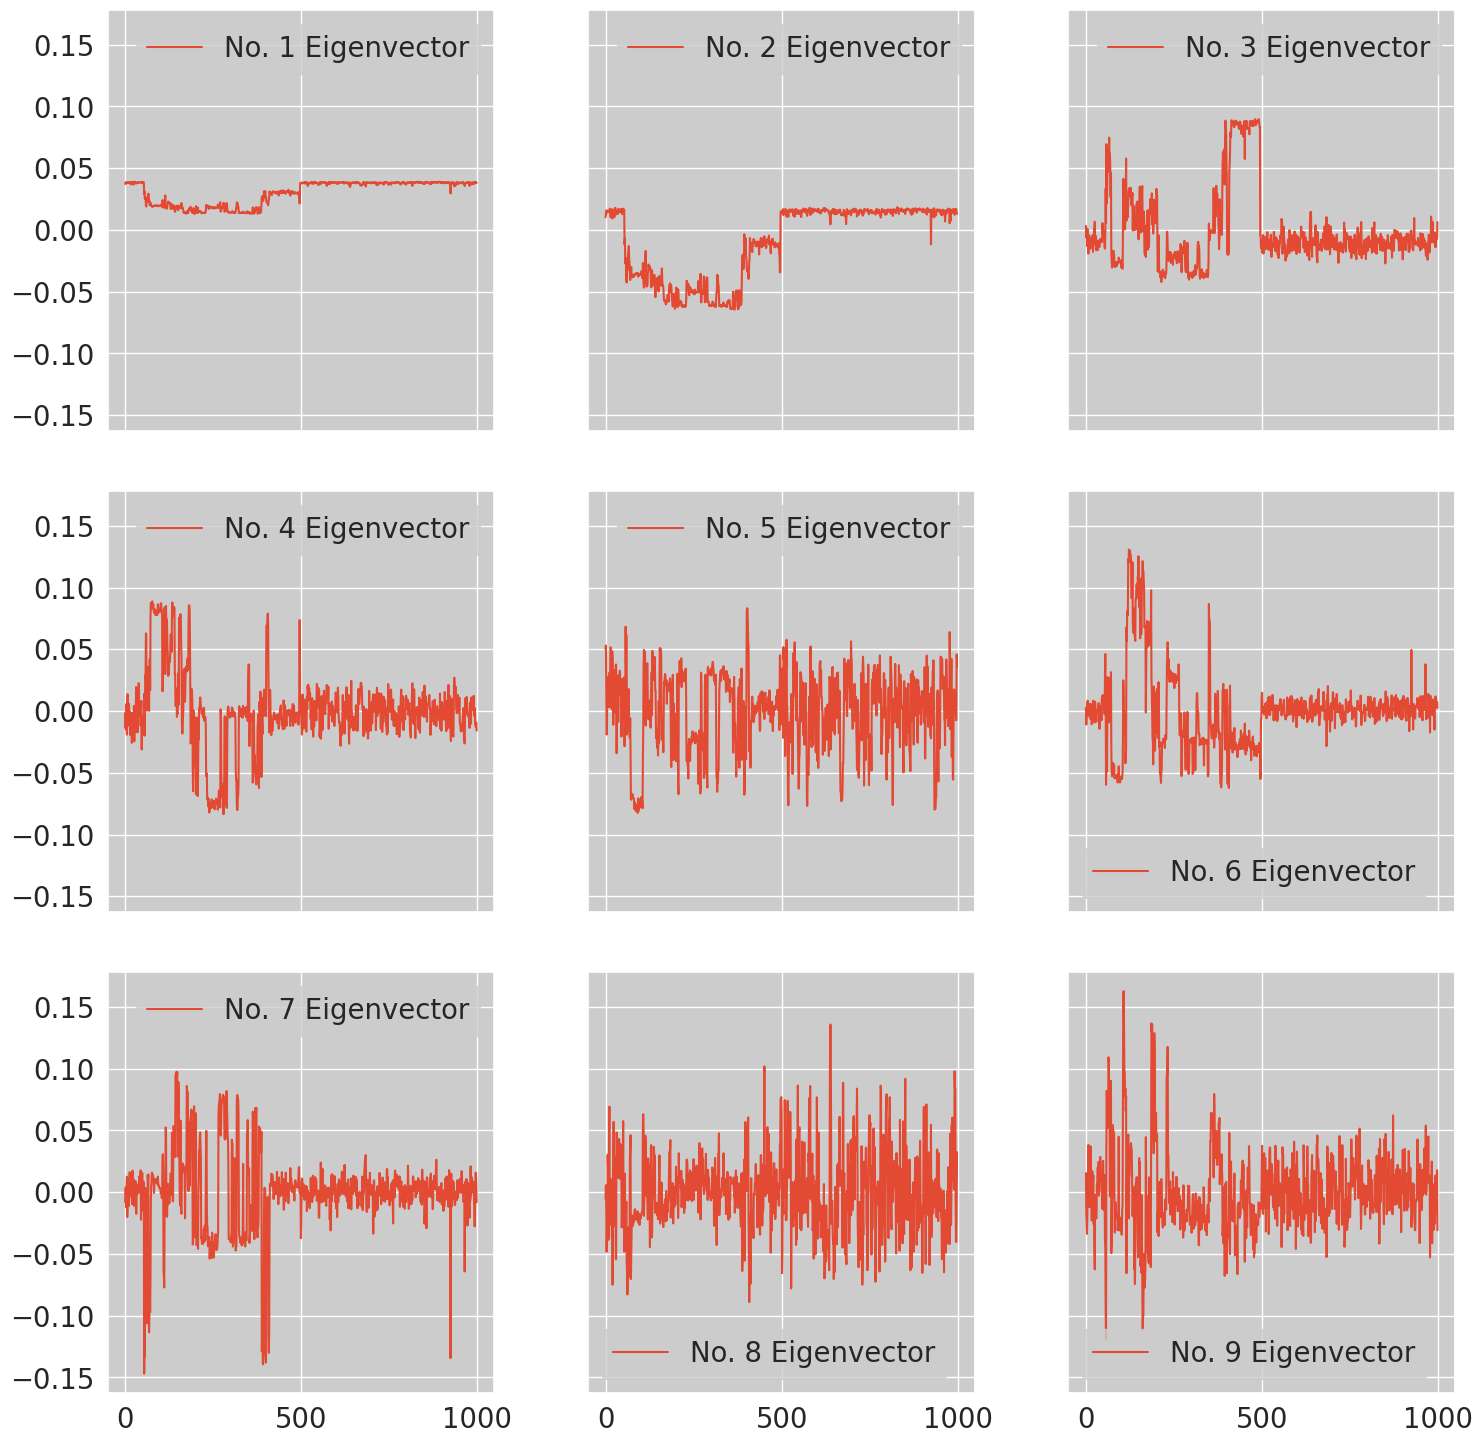

In [15]:
fig, axs = plt.subplots(3,3,sharex=True,sharey=True, figsize=(15,15)) 
sel = range(0,np.size(axs))
fig.tight_layout()
for ax, key in zip(axs.reshape(len(sel)), sel): 
    ax.plot(v[:,key])
    ax.legend(labels =["No. " + str(key+1) + " Eigenvector"])

## Testing Lapacian Matrix

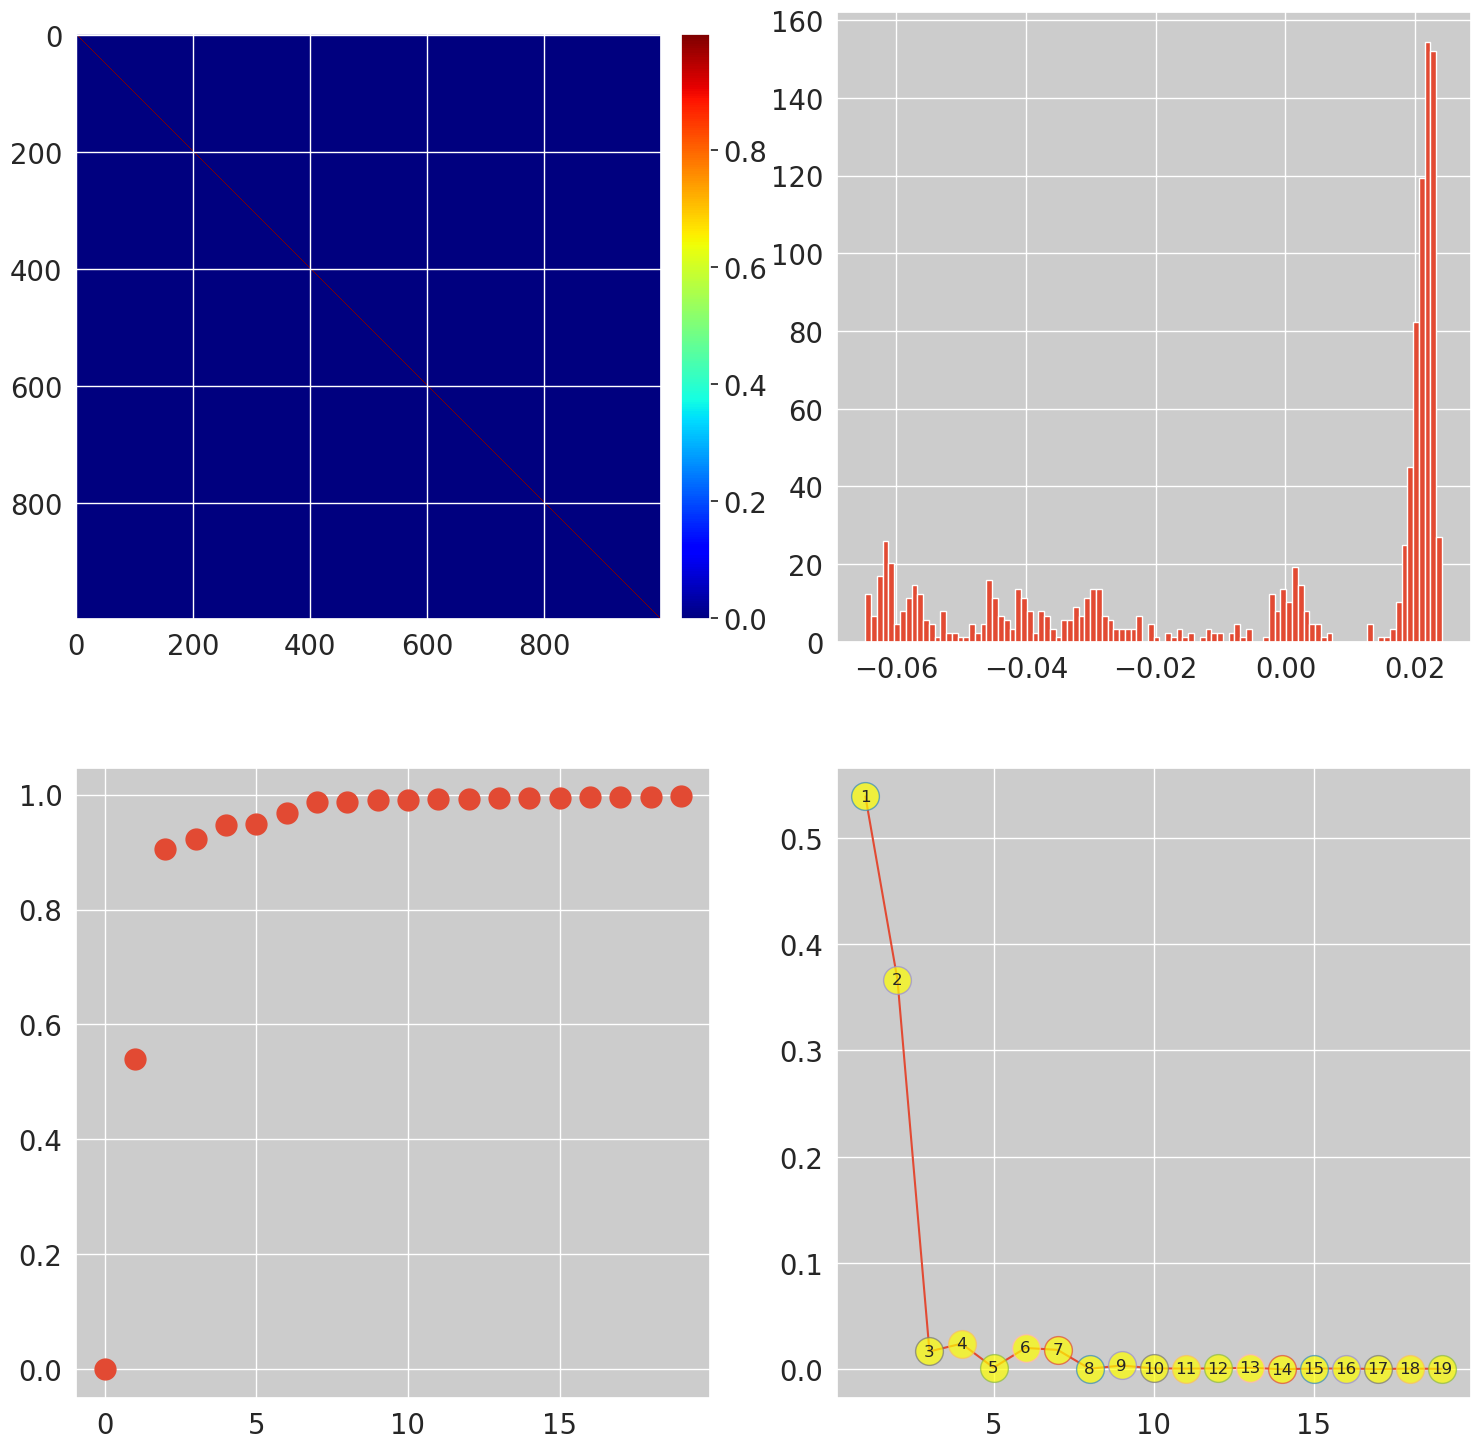

In [16]:
### Lapalacian Matrix
Nmat = bt.Lmat.NLmat_sym(Smaty)
w,v  = np.linalg.eig(Nmat)

## plot data
fig, axs = plt.subplots(2,2,figsize=(18,18)) 
bt.plot.implot(Nmat, axs[0,0])
hist = axs[0,1].hist(v[:,1], bins=100, density=True)
axs[1,0].plot(w[0:20], "o")
eg = w[1:20] - w[0:19]
bt.plot.coefplot(eg, axs[1,1])

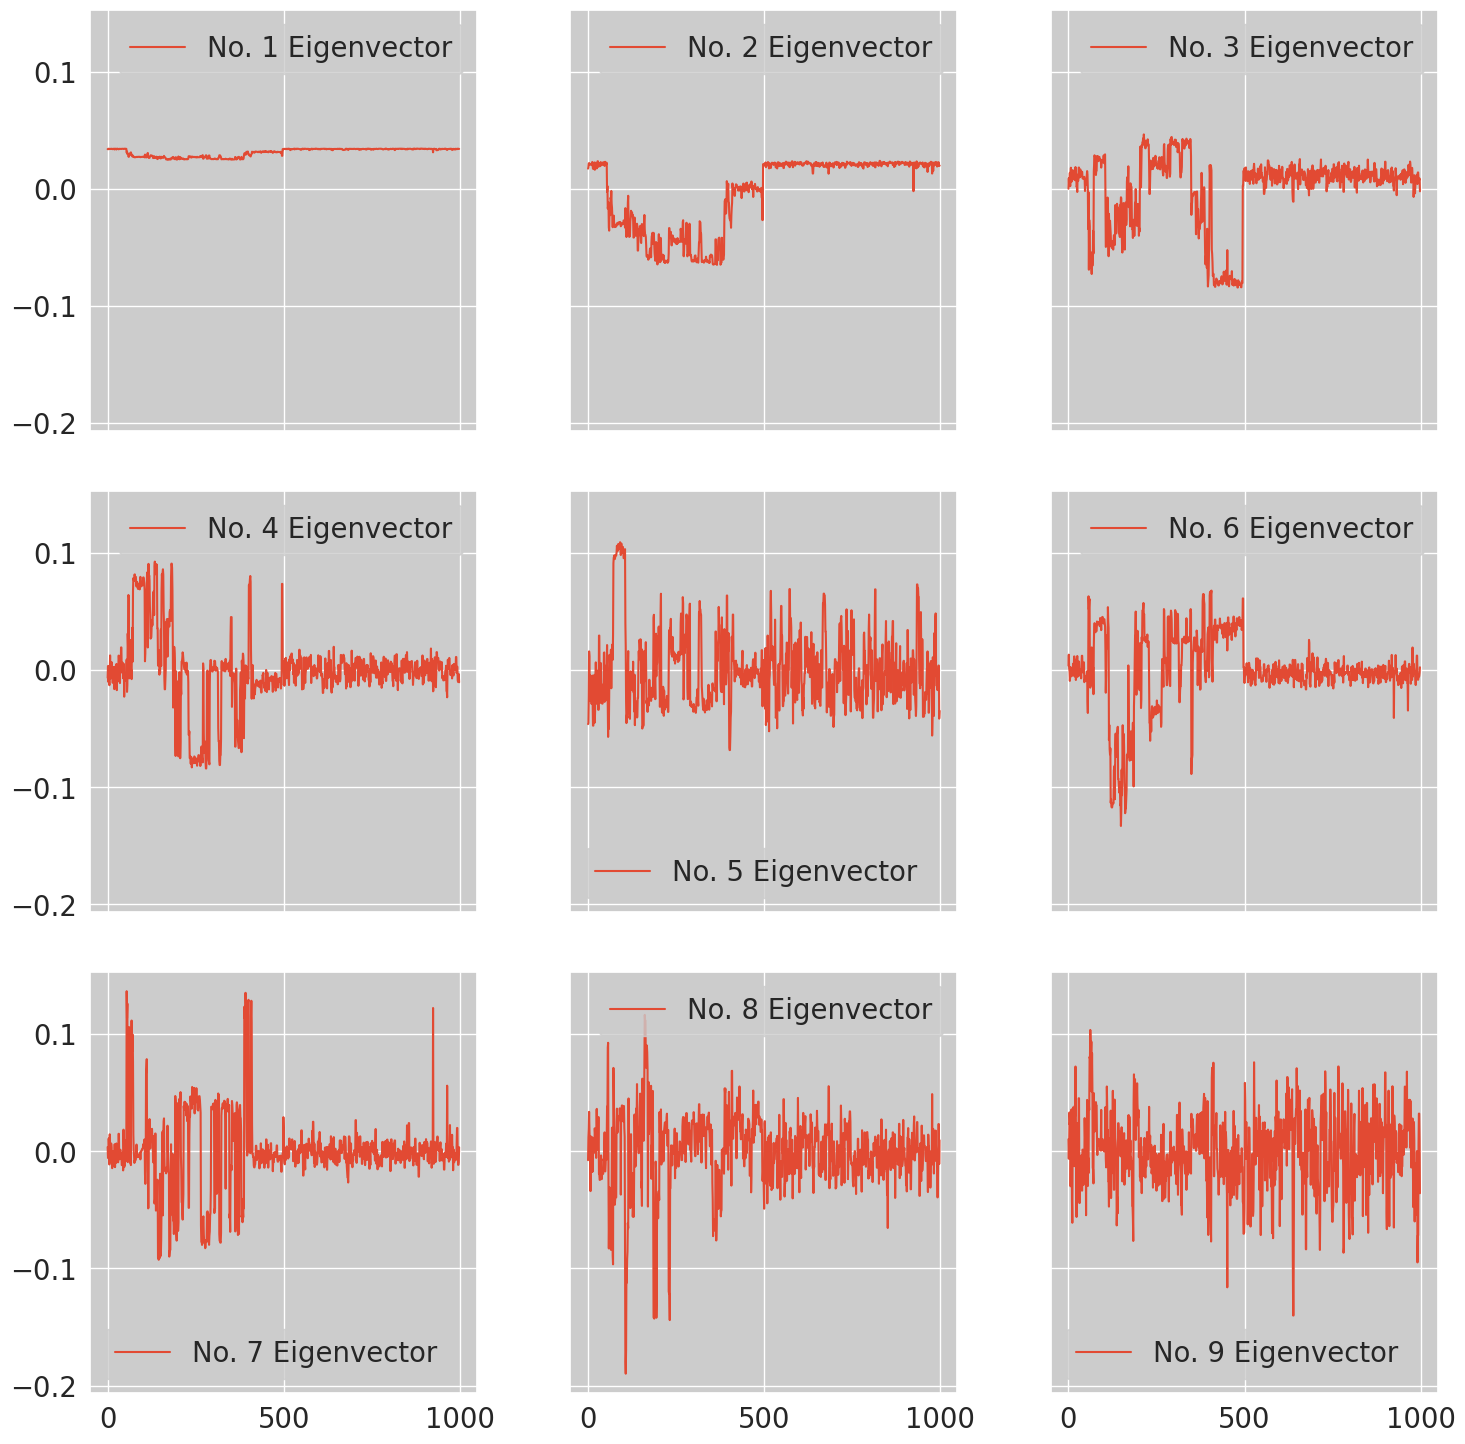

In [17]:
fig, axs = plt.subplots(3,3,sharex=True,sharey=True, figsize=(15,15)) 
sel = range(0,np.size(axs))
fig.tight_layout()
for ax, key in zip(axs.reshape(len(sel)), sel): 
    ax.plot(v[:,key])
    ax.legend(labels =["No. " + str(key+1) + " Eigenvector"])

# Clustering

## Clustering by Kmeans

In [18]:
## Test KMean parameters
def testKMn(n):
    cl = KMeans(n_clusters=n,n_init=50).fit_predict(Xys)
    return evalute(Xys, cl)

score_KMean = pd.DataFrame({'ncluster':np.arange(2,10)})
score_KMean['score'] = score_KMean['ncluster'].apply(testKMn)

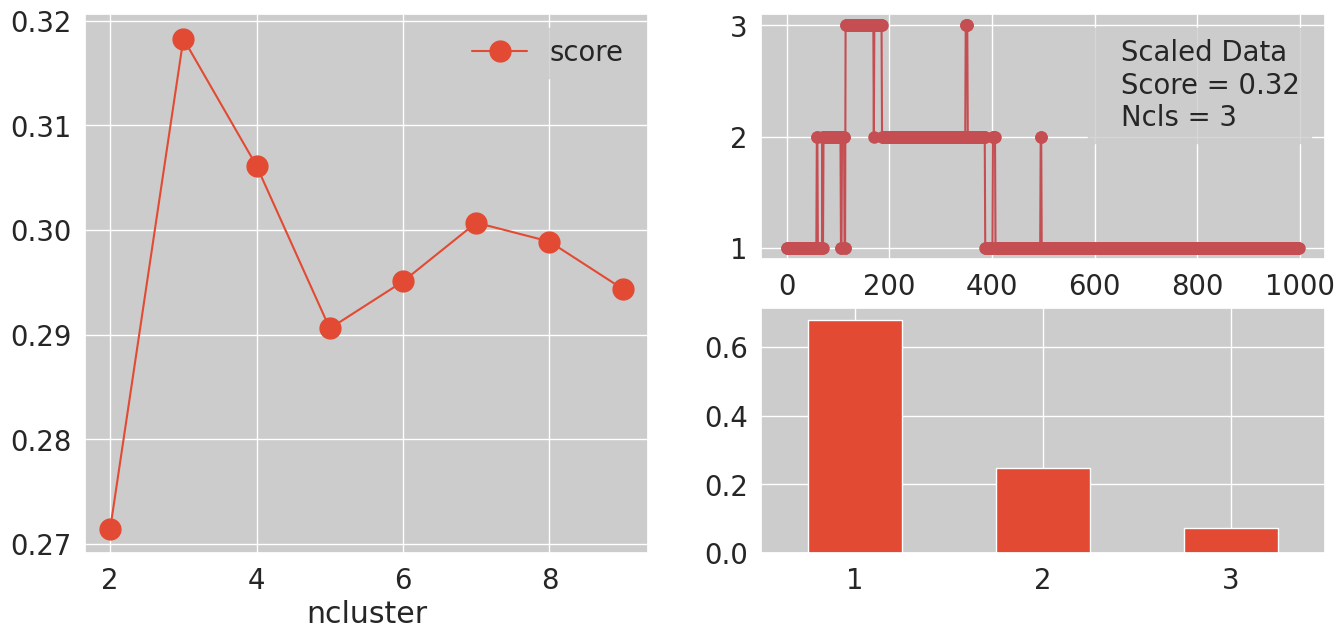

In [44]:
idxPeak = score_KMean['score'].idxmax();
ncls = score_KMean.loc[idxPeak,'ncluster']
cl = KMeans(n_clusters=ncls,n_init=50).fit_predict(Xys)
lab = "Scaled Data\nScore = {:.2f}\nNcls = {:d}".format(evalute(Xys, cl), ncls)

## plot data
bt.plot.clplot(score_KMean.set_index('ncluster'), cl, lab)

## Clustering by KMediods

### KMediods by Trajectory

In [20]:
## Testing Kmediods parameters by trajectory
def testKMs(n):
    cl = KMedoids(n_clusters=n).fit_predict(Xys)
    return evalute(Xys, cl)

score_KMedoids = pd.DataFrame({'ncluster':np.arange(2,10)})
score_KMedoids['score'] = score_KMedoids['ncluster'].apply(testKMs)

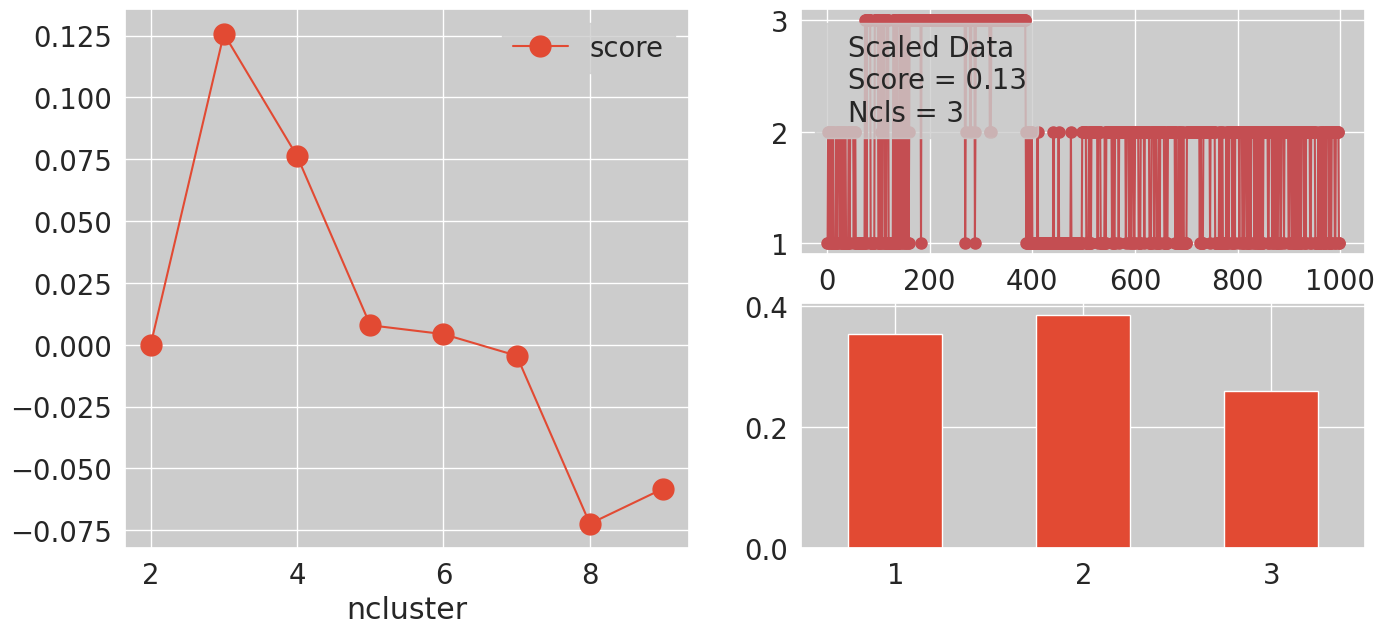

In [45]:
idxPeak = score_KMedoids['score'].idxmax();
ncls = score_KMedoids.loc[idxPeak,'ncluster']
cl = KMedoids(n_clusters=ncls).fit_predict(Xys)
lab = "Scaled Data\nScore = {:.2f}\nNcls = {:d}".format(evalute(Xys, cl), ncls)

### plot data
bt.plot.clplot(score_KMedoids.set_index('ncluster'), cl, lab)

### KMedoids by Matrix

In [22]:
## Testing Kmedoids by matrix
Dmat = 1.001 - Smaty
def testKMsm(n):
    cl = KMedoids(n_clusters=n, metric='precomputed').fit_predict(Dmat)
    return evalute(Xys, cl)

### get the score
score_KMedoidsMat = pd.DataFrame({'ncluster':np.arange(2,10)})
score_KMedoidsMat['score'] = score_KMedoidsMat['ncluster'].apply(testKMsm)

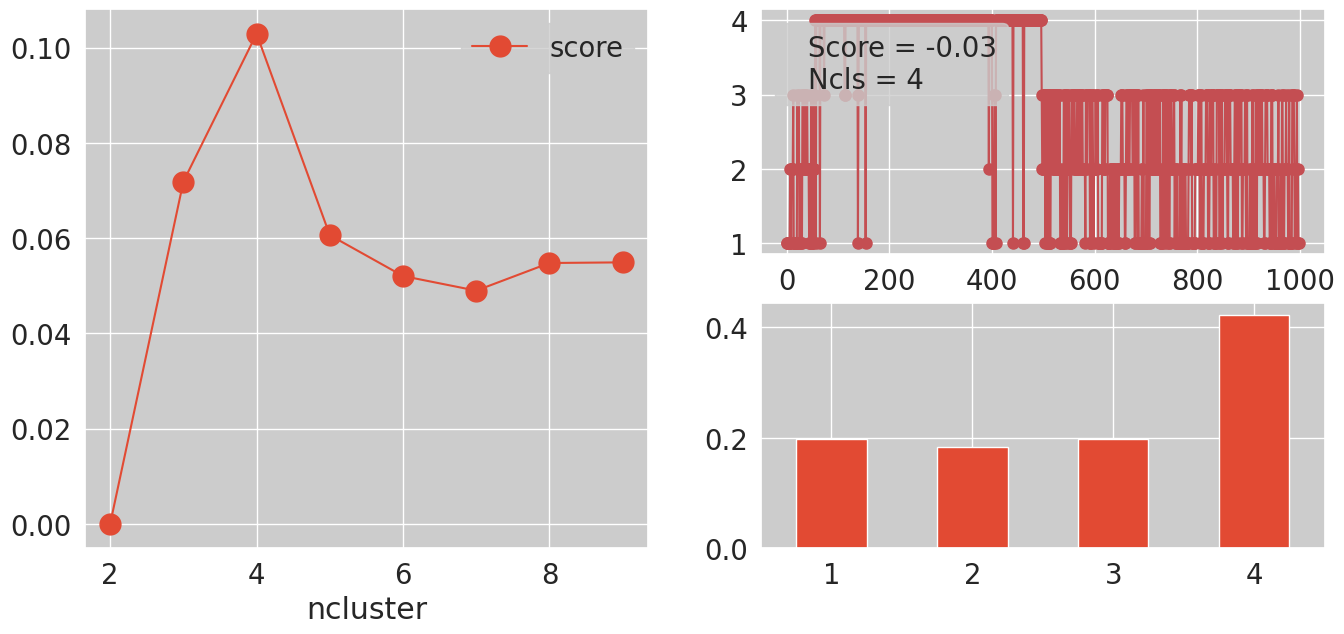

In [46]:
### find the top score parameter
idxPeak = score_KMedoidsMat['score'].idxmax();
ncls = score_KMedoidsMat.loc[idxPeak,'ncluster']
cl = KMedoids(n_clusters=ncls, metric='precomputed').fit_predict(Dmat)
lab = "Score = {:.2f}\nNcls = {:d}".format(evalute(Xys, cl), ncls)

### plot data
bt.plot.clplot(score_KMedoidsMat.set_index('ncluster'), cl, lab)

## Clustering by GMM

In [58]:
# Test KMean parameters
def testGMM(n):
    cl = GaussianMixture(n_components=n,n_init=50).fit_predict(Xys)
    return evalute(Xys, cl)

score_GMM = pd.DataFrame({'ncluster':np.arange(2,10)})
score_GMM['score'] = score_GMM['ncluster'].apply(testGMM)

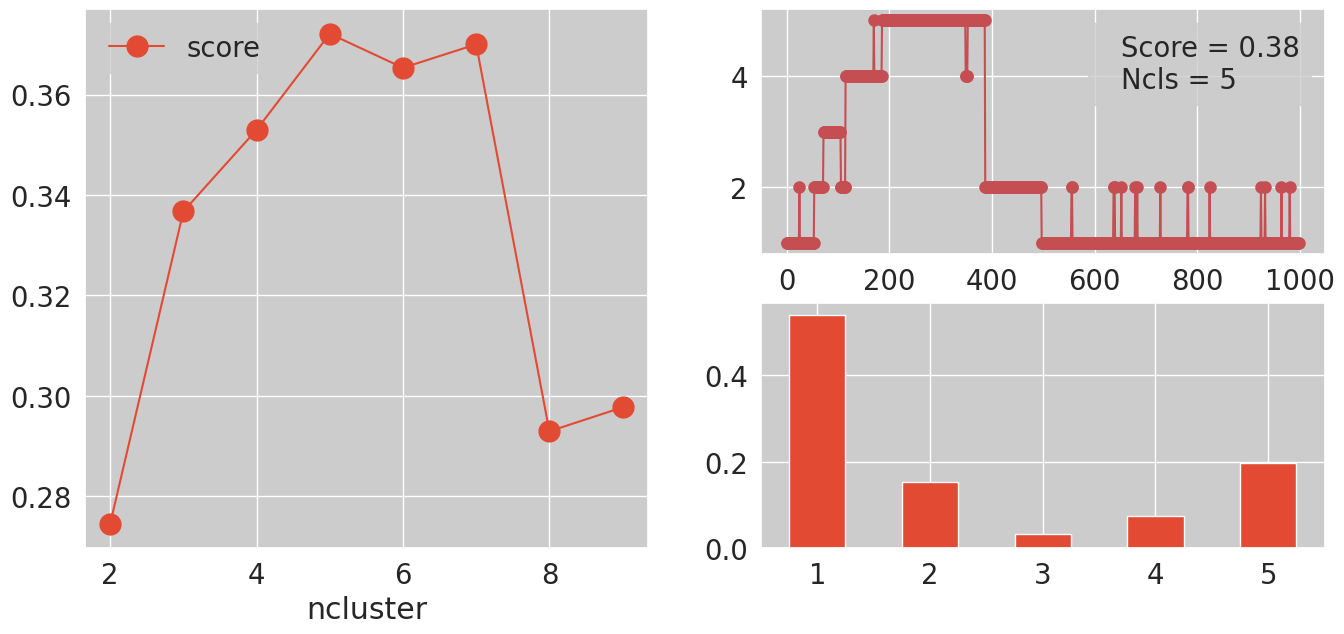

In [59]:
### find the top score parameter
idxPeak = score_GMM['score'].idxmax();
ncls = score_GMM.loc[idxPeak,'ncluster']
cl = GaussianMixture(n_components=ncls, n_init=50).fit_predict(Xys)
lab = "Score = {:.2f}\nNcls = {:d}".format(evalute(Xys, cl), ncls)

### plot data
bt.plot.clplot(score_GMM.set_index('ncluster'), cl, lab)

## Clustering by Spectral Clustering

### Spectral Clustering by Matrix

In [26]:
## Testing Spectral Clustering by matrix
def testSC(n):
    cl = SpectralClustering(n_clusters=n, affinity='precomputed').fit_predict(Smaty)
    return evalute(Xys, cl)

### get the score
score_SpectralMat = pd.DataFrame({'ncluster':np.arange(2,10)})
score_SpectralMat['score'] = score_SpectralMat['ncluster'].apply(testSC)

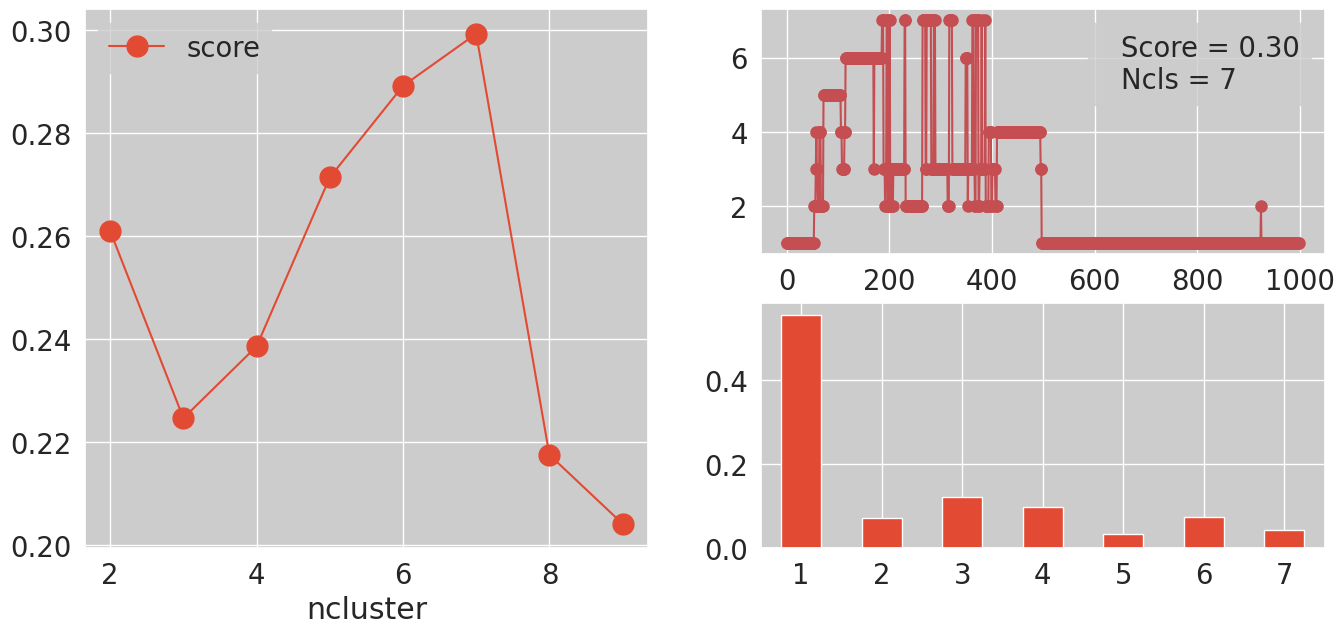

In [48]:
### find the top score parameter
idxPeak = score_SpectralMat['score'].idxmax();
ncls = score_SpectralMat.loc[idxPeak,'ncluster']
cl = SpectralClustering(n_clusters=ncls, affinity='precomputed').fit_predict(Smaty)
lab = "Score = {:.2f}\nNcls = {:d}".format(evalute(Xys, cl), ncls)

### plot data
bt.plot.clplot(score_SpectralMat.set_index('ncluster'), cl, lab)

### Spectral Clustering by Trajectory

In [28]:
score_Spectral = pd.DataFrame(columns=["gamma", "ncls", "score"])
for gamma in [1, 10, 100]:
    for ncls in np.arange(2,10):
        cl = SpectralClustering(n_clusters=ncls, gamma=gamma).fit_predict(Xys)
        score_Spectral.loc[len(score_Spectral.index)] = [gamma, ncls, evalute(Xys, cl)]

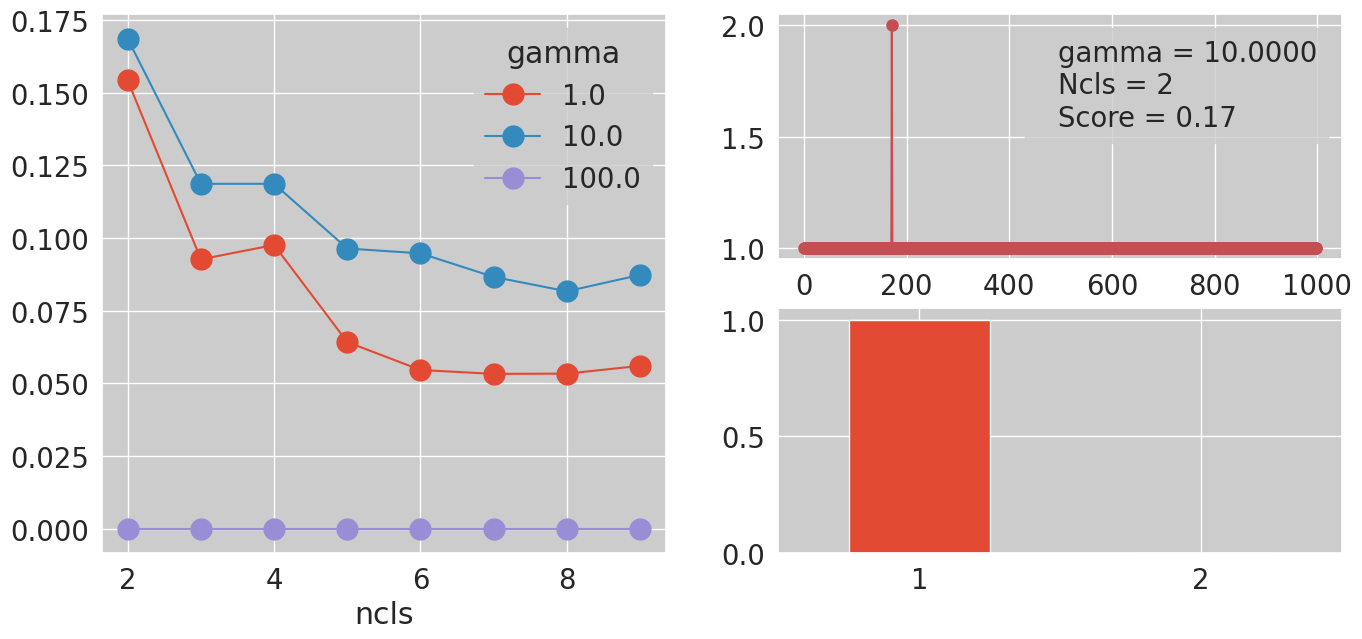

In [49]:
idxPeak = score_Spectral['score'].idxmax();
gamma   = score_Spectral.loc[idxPeak,"gamma"]
ncls    = score_Spectral.loc[idxPeak, "ncls"].astype(int)
cl  = SpectralClustering(n_clusters=ncls, gamma=gamma).fit_predict(Xys)
lab = "gamma = {:.4f}\nNcls = {:d}\nScore = {:.2f}".format(gamma, ncls, evalute(Xys, cl))

### plot data
bt.plot.clplot(score_Spectral.pivot(index='ncls', columns="gamma", values="score"), cl, lab)

## Clustering by PCCA+

In [30]:
### Testing PCCA paraters
def testPCCA(n):
    cl = PCCA(Tmat, n)
    return evalute(Xys, cl.metastable_assignment)

### get the score
Tmat = np.array(Smaty/Smaty.sum(axis=1))
score_PCCA = pd.DataFrame({'ncluster':np.arange(2,10)})
score_PCCA['score'] = score_PCCA['ncluster'].apply(testPCCA)

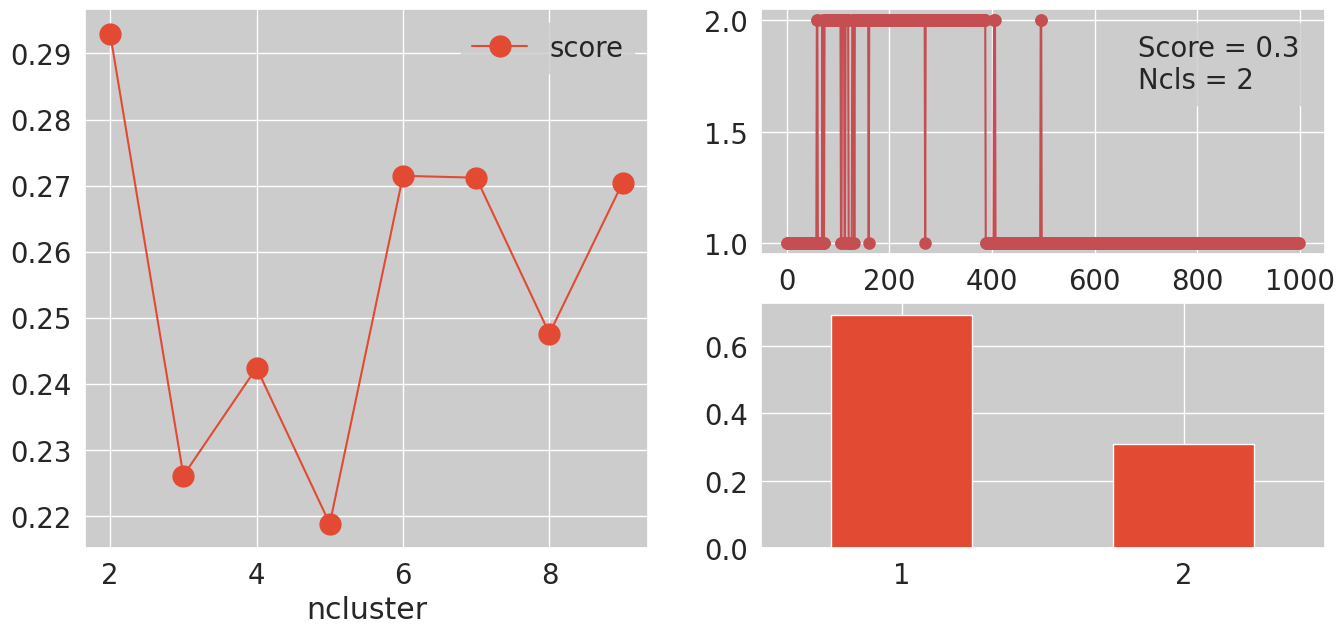

In [50]:
### find the top score parameter
idxPeak = score_PCCA ['score'].idxmax();
ncls = score_PCCA.loc[idxPeak,'ncluster']
cl = PCCA(Tmat, ncls)
lab = "Score = {:.1f}\nNcls = {:d}".format(
        evalute(Xys, cl.metastable_assignment), cl.n_metastable)

### plot data
bt.plot.clplot(score_PCCA.set_index("ncluster"), cl.metastable_assignment, lab)

## Clustering by DBSCAN

In [32]:
## Testing DBSCAN parameters
score_DBSCAN = pd.DataFrame(columns=["cutoff", "Min Samples", "score"])
for f in np.arange(0.2, 0.6, 0.1)*np.linalg.norm(np.std(Xys, axis=0)):
    for n in np.arange(5,15):
        cl = DBSCAN(eps=f, min_samples=n).fit_predict(Xys)
        score_DBSCAN.loc[len(score_DBSCAN.index)] = [f, n, evalute(Xys, cl)]     

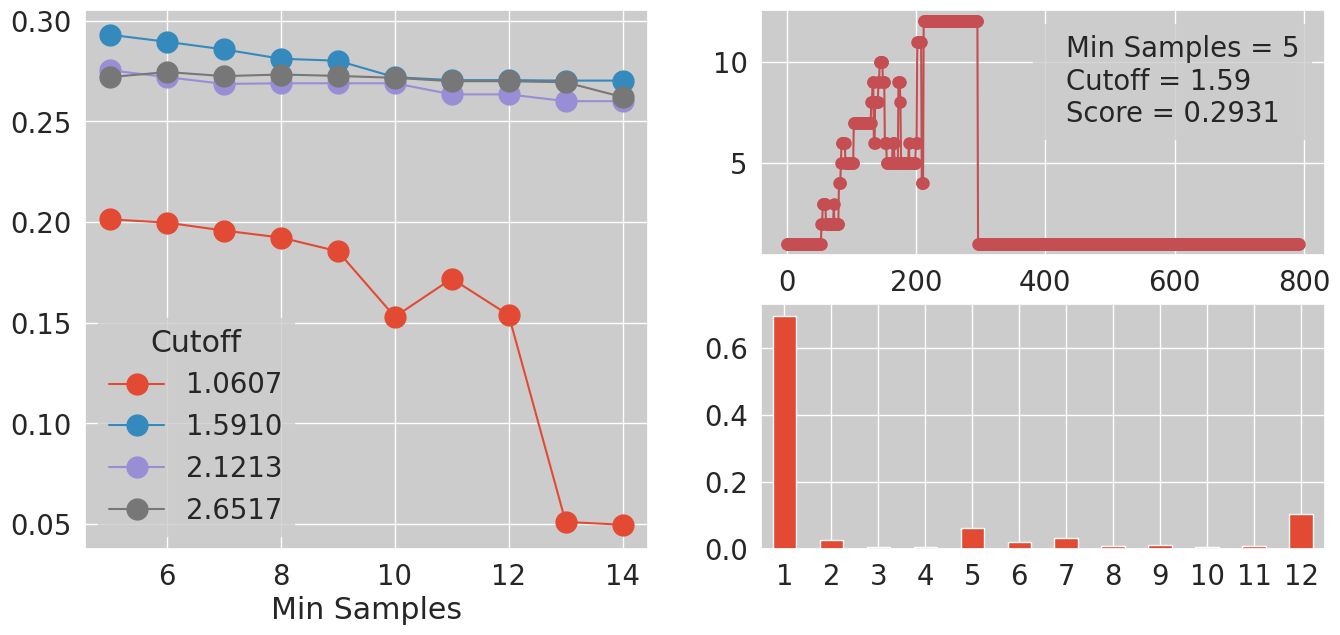

In [51]:
### the opt parameter
idxPeak = score_DBSCAN['score'].idxmax();
f  = score_DBSCAN.loc[idxPeak,"cutoff"]
n  = score_DBSCAN.loc[idxPeak, "Min Samples"].astype(int)
cl = DBSCAN(eps=f, min_samples=n).fit_predict(Xys)
lab = "Min Samples = {:d}\nCutoff = {:.2f}\nScore = {:.4f}".format(n, f, evalute(Xys, cl))
cl  = cl[cl != -1]

#### plot data
score_DBSCAN['Cutoff'] = score_DBSCAN['cutoff'].map(lambda x:('%.4f')%x)
bt.plot.clplot(score_DBSCAN.pivot(index='Min Samples', columns="Cutoff", values="score"), cl, lab)

# Clustering by Original Data

## Clustering by Kmeans

In [34]:
## Test KMean parameters
def testKMn0(n):
    cl = KMeans(n_clusters=n,n_init=50).fit_predict(X0s)
    return evalute(X0s, cl)

score_KMean0 = pd.DataFrame({'ncluster':np.arange(2,10)})
score_KMean0['score'] = score_KMean0['ncluster'].apply(testKMn0)

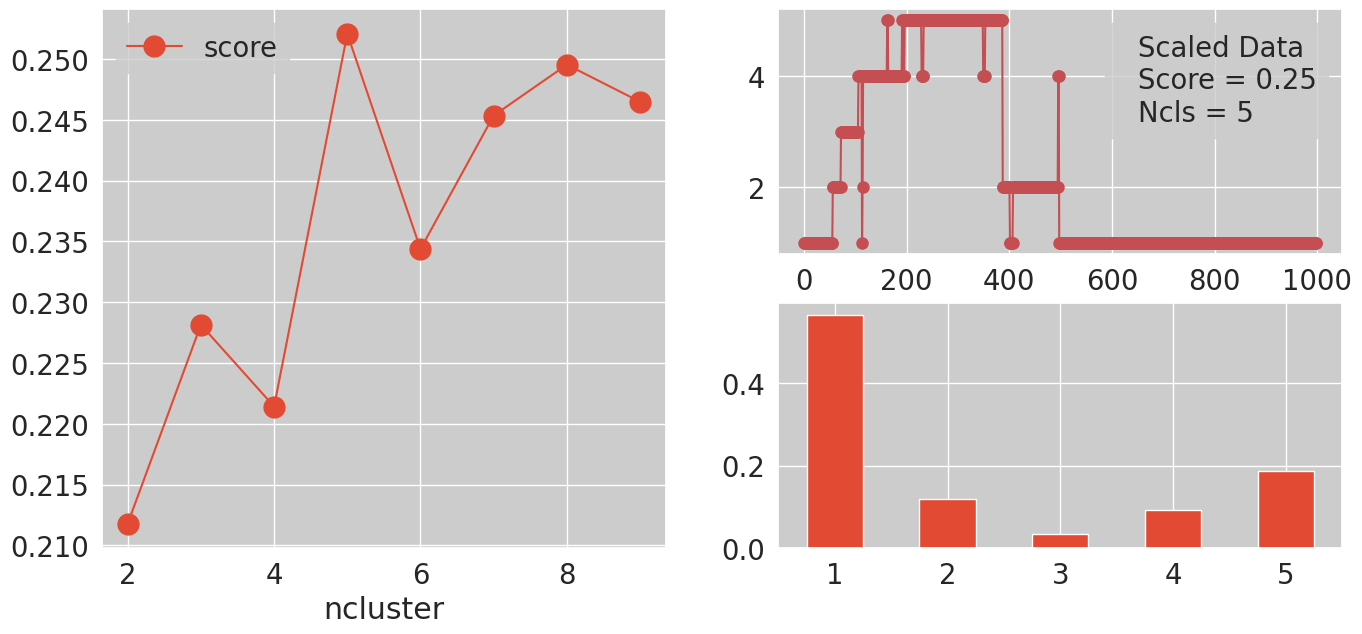

In [52]:
idxPeak = score_KMean0['score'].idxmax();
ncls = score_KMean.loc[idxPeak,'ncluster']
cl = KMeans(n_clusters=ncls,n_init=50).fit_predict(X0s)
lab = "Scaled Data\nScore = {:.2f}\nNcls = {:d}".format(evalute(X0s, cl), ncls)

## plot data
bt.plot.clplot(score_KMean0.set_index('ncluster'), cl, lab)

## Clustering by KMediods

### KMediods by Trajectory

In [36]:
## Testing Kmediods parameters by trajectory
def testKMs0(n):
    cl = KMedoids(n_clusters=n).fit_predict(X0s)
    return evalute(Xys, cl)

score_KMedoids0 = pd.DataFrame({'ncluster':np.arange(2,10)})
score_KMedoids0['score'] = score_KMedoids0['ncluster'].apply(testKMs0)

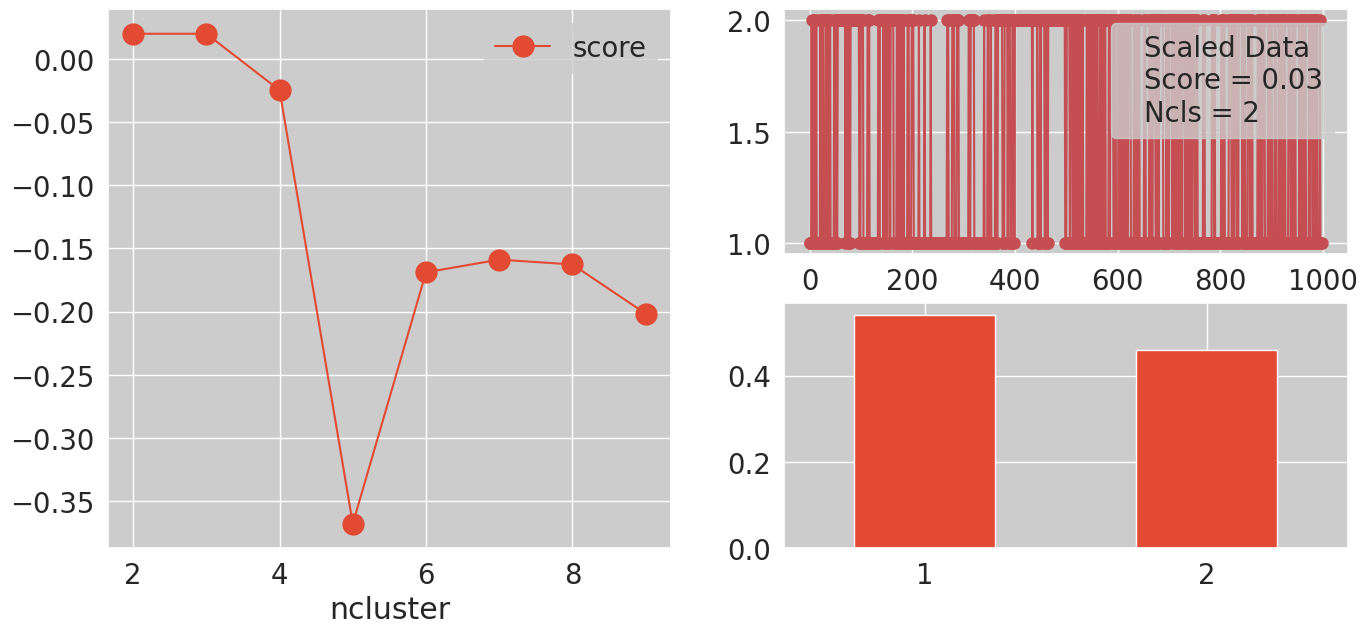

In [53]:
idxPeak = score_KMedoids0['score'].idxmax();
ncls = score_KMedoids0.loc[idxPeak,'ncluster']
cl = KMedoids(n_clusters=ncls).fit_predict(X0s)
lab = "Scaled Data\nScore = {:.2f}\nNcls = {:d}".format(evalute(X0s, cl), ncls)

### plot data
bt.plot.clplot(score_KMedoids0.set_index('ncluster'), cl, lab)

### KMedoids by Matrix

In [38]:
## Testing Kmedoids by matrix
Dmat = 1.001 - Smat0
def testKMsm(n):
    cl = KMedoids(n_clusters=n, metric='precomputed').fit_predict(Dmat)
    return evalute(X0s, cl)

### get the score
score_KMedoidsMat0 = pd.DataFrame({'ncluster':np.arange(2,10)})
score_KMedoidsMat0['score'] = score_KMedoidsMat0['ncluster'].apply(testKMsm)

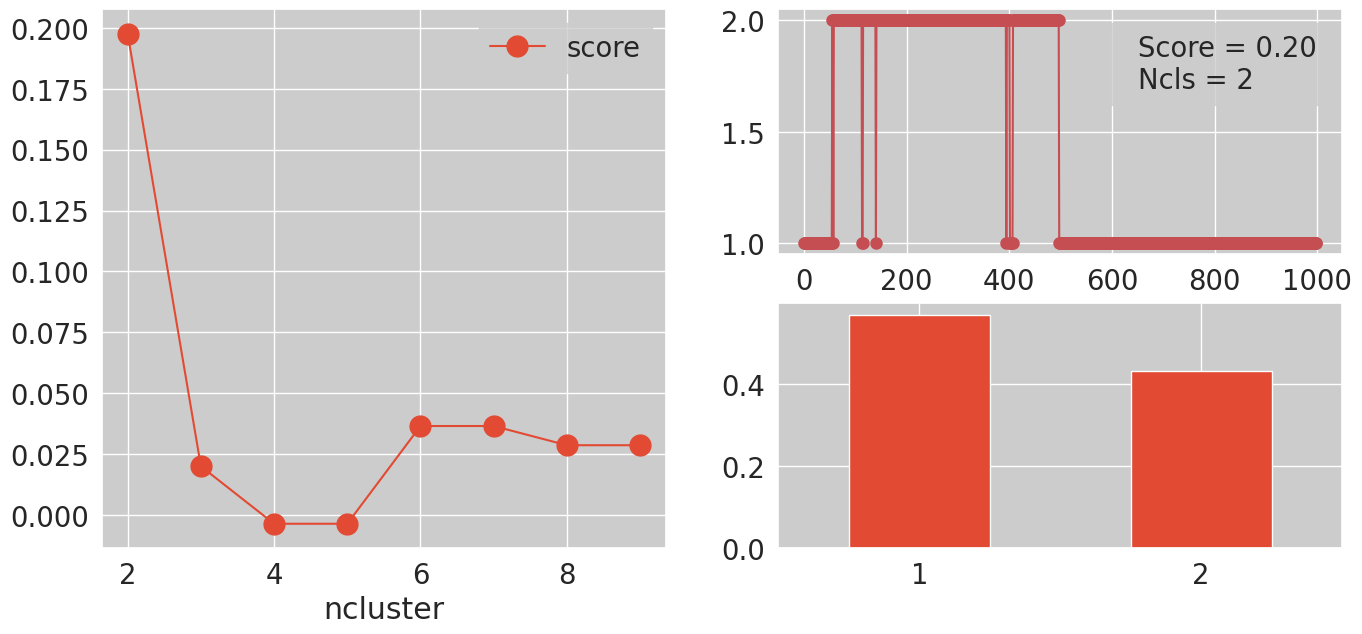

In [54]:
### find the top score parameter
idxPeak = score_KMedoidsMat0['score'].idxmax();
ncls = score_KMedoidsMat0.loc[idxPeak,'ncluster']
cl = KMedoids(n_clusters=ncls, metric='precomputed').fit_predict(Dmat)
lab = "Score = {:.2f}\nNcls = {:d}".format(evalute(X0s, cl), ncls)

### plot data
bt.plot.clplot(score_KMedoidsMat0.set_index('ncluster'), cl, lab)

## Clustering by GMM

In [40]:
# Test KMean parameters
def testGMM0(n):
    cl = GaussianMixture(n_components=n,n_init=50).fit_predict(X0s)
    return evalute(X0s, cl)

score_GMM0 = pd.DataFrame({'ncluster':np.arange(2,10)})
score_GMM0['score'] = score_GMM0['ncluster'].apply(testGMM0)

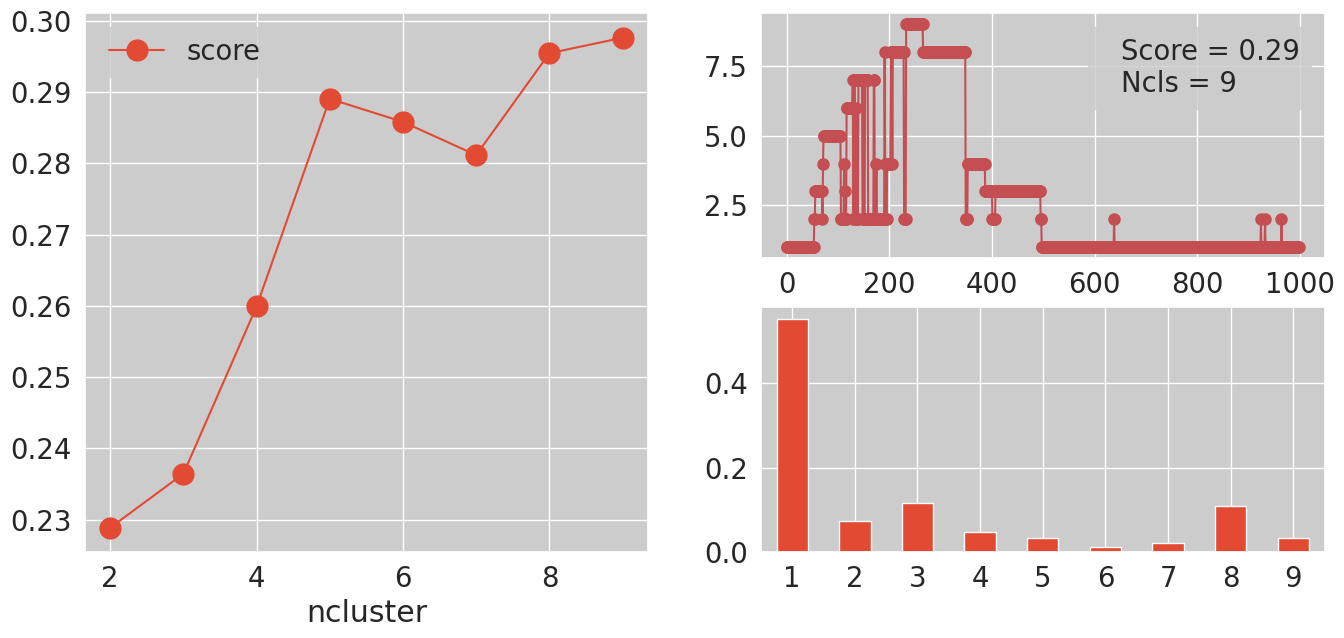

In [55]:
### find the top score parameter
idxPeak = score_GMM0['score'].idxmax();
ncls = score_GMM0.loc[idxPeak,'ncluster']
cl = GaussianMixture(n_components=ncls, n_init=50).fit_predict(X0s)
lab = "Score = {:.2f}\nNcls = {:d}".format(evalute(X0s, cl), ncls)

### plot data
bt.plot.clplot(score_GMM0.set_index('ncluster'), cl, lab)

# Save Data

In [56]:
## save current ipynb
from ipylab import JupyterFrontEnd
app = JupyterFrontEnd()
app.commands.execute('docmanager:save')

In [57]:
## record output to pdf
#nbname = os.path.basename(app.sessions.get_state().get('current_session').get('path'))
nbname = 'EscalTM-soloTraj.ipynb'
srcpath = %pwd
srcfile = f"{srcpath}/{nbname}"

!jupyter nbconvert --to pdf --no-input --log-level 40 \
    --output-dir {datadir} --output "EscalTM-"{fname}".pdf" \
    {srcfile}